<a href="https://colab.research.google.com/github/viveksinha-git/IDfy/blob/main/OCR_for_License_Plate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IDfy Assignment

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import os
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
os.chdir("/content/gdrive/My Drive/IDfy/")
!pwd

/content/gdrive/My Drive/IDfy


In [4]:
MIN_CONTOUR_AREA = 100    # minimum area for contour to be considered
MAX_CONTOUR_AREA = 1200   # maximum area to be considered
MASK_CONTOUR = 900        # cropping only the license plate and removing other noise
threshold = 170           # image thresholding

RESIZED_IMAGE_WIDTH = 200
RESIZED_IMAGE_HEIGHT = 80

In [5]:
# Loading the dataset
dataset = pd.read_csv('dataset.csv', names=["Path","Plate Number"])

def file_path(dataset):
    images = []
    for i in range(5):
        images.append(dataset["Path"][i])
    return images

images = file_path(dataset)
print(images)

['crop_m1/I00000.png', 'crop_h1/I00000.png', 'crop_m1/I00001.png', 'crop_h1/I00001.png', 'crop_m1/I00002.png']


In [6]:
# Defining Helper Functions

def get_image(image):
    imgTrainingNumbers = cv2.imread(image)
    return imgTrainingNumbers

def preprocessing(image):
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur_image = cv2.GaussianBlur(gray_image,(5,5),0)
    imgThresh = cv2.adaptiveThreshold(blur_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    #canny_edges = cv2.Canny(blur_image, 70, 150)
    return imgThresh

def initialize_params(RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT):
    dim = (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT)
    intClassifications = []         # declare empty classifications list

    intValidChars = [ord('0'), ord('1'), ord('2'), ord('3'), ord('4'), ord('5'), ord('6'), ord('7'), ord('8'), ord('9'),
                     ord('A'), ord('B'), ord('C'), ord('D'), ord('E'), ord('F'), ord('G'), ord('H'), ord('I'), ord('J'),
                     ord('K'), ord('L'), ord('M'), ord('N'), ord('O'), ord('P'), ord('Q'), ord('R'), ord('S'), ord('T'),
                     ord('U'), ord('V'), ord('W'), ord('X'), ord('Y'), ord('Z')]
    
    return dim, intClassifications, intValidChars

def get_cropped_image(imgThreshCopy, MASK_CONTOUR, original_resized):
    npaContours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    npaContours = sorted(npaContours, key=cv2.contourArea)
    for npaContour in npaContours:                         # for each contour
        if (cv2.contourArea(npaContour) > MASK_CONTOUR):          # if contour is big enough to consider
            [intX, intY, intW, intH] = cv2.boundingRect(npaContour)         # get and break out bounding rect
            #cv2.rectangle(original_resized, (intX, intY), (intX+intW,intY+intH), (0, 0, 255), 2)

            perimeter = cv2.arcLength(npaContour, True)
            approx = cv2.approxPolyDP(npaContour, 0.01*perimeter, True)

            # Masking the part other than the number plate
            mask = np.zeros(imgThreshCopy.shape,np.uint8)
            new_image = cv2.drawContours(mask,[approx],0,255,-1,)
            new_image = cv2.bitwise_and(original_resized,original_resized,mask=mask)
            #resized_plate = cv2.resize(new_image,(RESIZED_IMAGE_WIDTH,RESIZED_IMAGE_HEIGHT))
            #print(resized_plate.shape)                # (80, 200)
            
            # Now crop
            (x, y) = np.where(mask == 255)
            (topx, topy) = (np.min(x), np.min(y))
            (bottomx, bottomy) = (np.max(x), np.max(y))
            cropped = original_resized[topx:bottomx+1, topy:bottomy+1]
            #cv2.imwrite("cropped_image.png", cropped)
            #time.sleep(0.1)
            #cv2.imshow("new_image", cropped)
            #cv2.waitKey(0)                             # wait for user key press
            return cropped

def get_contours(imgThreshCopy, MIN_CONTOUR_AREA, MAX_CONTOUR_AREA, original_resized):
    npaContours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #npaContours = sorted(npaContours, key=cv2.contourArea, reverse=True)
    #npaContours = sorted(npaContours, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1] * imgThreshCopy.shape[0])
    
    for npaContour in npaContours:                         # for each contour
        if (cv2.contourArea(npaContour) > MIN_CONTOUR_AREA and cv2.contourArea(npaContour) < MAX_CONTOUR_AREA):          # if contour is big enough to consider
            #original_resized = cv2.drawContours(original_resized, npaContour, -1, (0,255,0), 3)
            [intX, intY, intW, intH] = cv2.boundingRect(npaContour)         # get and break out bounding rect
            cv2.rectangle(original_resized, (intX, intY), (intX+intW,intY+intH), (0, 255, 0), 2)

            perimeter = cv2.arcLength(npaContour, True)
            approx = cv2.approxPolyDP(npaContour, 0.01*perimeter, True)

            # Masking the part other than the number plate
            #mask = np.zeros(imgThreshCopy.shape,np.uint8)
            #new_image = cv2.drawContours(mask,[approx],0,255,-1,)
            #new_image = cv2.bitwise_and(original_resized,original_resized,mask=mask)
            #resized_plate = cv2.resize(new_image,(RESIZED_IMAGE_WIDTH,RESIZED_IMAGE_HEIGHT))
            #print(resized_plate.shape)                # (80, 200)
            cv2_imshow(original_resized)
            cv2.waitKey(0)                             # wait for user key press
                
    return 1

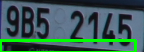

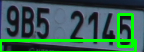

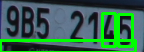

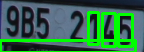

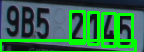

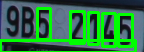

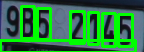

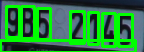

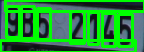

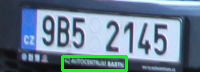

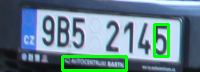

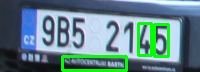

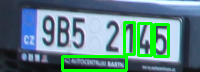

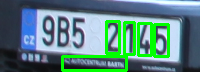

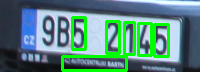

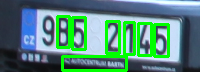

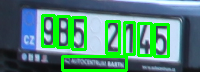

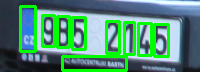

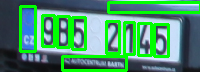

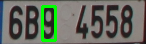

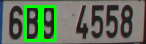

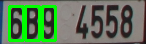

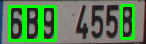

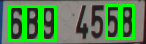

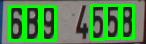

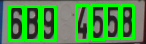

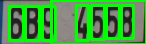

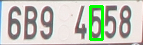

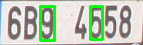

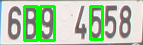

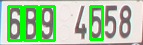

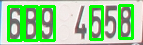

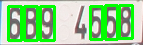

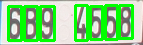

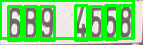

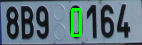

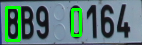

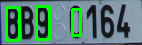

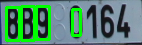

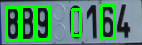

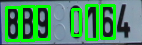

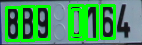

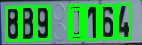

In [7]:
for image in images:
    original_image = get_image(image)
    thresh_image = preprocessing(original_image)
    imgThreshCopy = thresh_image.copy()        # make a copy of the thresh image, this in necessary b/c findContours modifies the image
    #plt.imshow(imgThreshCopy,'gray')
    
    dim, intClassifications, intValidChars = initialize_params(RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT)
    
    imgThreshCopy = cv2.resize(imgThreshCopy,dim)
    original_resized = cv2.resize(original_image,dim)       # original color image, resized version
    
    cropped_image = get_cropped_image(imgThreshCopy, MASK_CONTOUR, original_resized)
    #cropped_image = cv2.imread("cropped_image.png")
    thresh_image = preprocessing(cropped_image)
    imgThreshCopy = thresh_image.copy()
    masked_license_plate = get_contours(imgThreshCopy, MIN_CONTOUR_AREA, MAX_CONTOUR_AREA, cropped_image)